## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import kmapper as km
import networkx as nx
from sklearn import datasets
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion, Pipeline
from kmapper import jupyter

from giotto.mapper.cover import OneDimensionalCover, CubicalCover
from giotto.mapper.mapper import make_mapper_pipeline

import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions and classes

In [3]:
class Projection(BaseEstimator, TransformerMixin):
    def __init__(self, dimension):
        self.dimension = dimension
        
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X, y=None):
        return X[:,self.dimension].reshape(-1,1)

## Circles example

In [4]:
data = datasets.make_circles(n_samples=1000)[0]

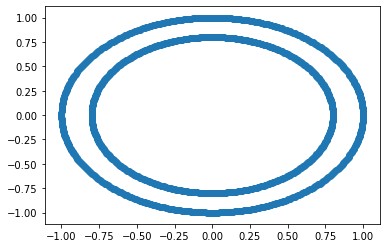

In [5]:
plt.scatter(data[:,0], data[:,1]);

### Kepler

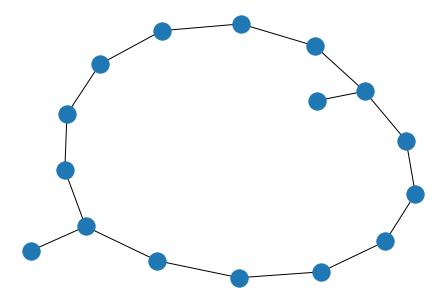

In [6]:
mapper_km = km.KeplerMapper()
lens_km = mapper_km.project(data)
graph_km = mapper_km.map(X=data, lens=lens_km)

nx_graph = km.adapter.to_nx(graph_km)
nx.draw(nx_graph)

### Giotto

In [7]:
filter_func = Projection(dimension=0)
cover = OneDimensionalCover()
clusterer = DBSCAN(eps=0.5)

In [8]:
n_jobs_outer = 1

pipe = make_mapper_pipeline(filter_func=filter_func,
                            cover=cover,
                            clusterer=clusterer,
                            verbose=True,
                            n_jobs_outer=n_jobs_outer)

In [9]:
graph_gl = pipe.fit_transform(data)

[Pipeline] ....... (step 1 of 2) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


/usr/local/anaconda3/envs/giotto-dev/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


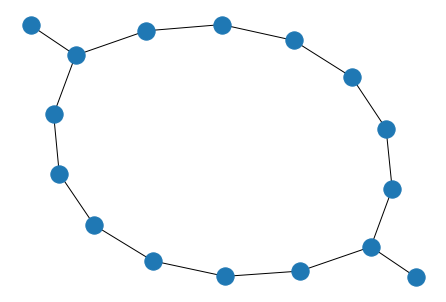

In [10]:
nx.draw(graph_gl)

## Breast cancer dataset
Download from Kaggle [here](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data) and store in `scratch/data/`.

In [11]:
DATA = Path('./data/')
!ls {DATA}

breast_cancer.csv


In [12]:
data = pd.read_csv(DATA/'breast_cancer.csv'); data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [13]:
feature_names = [c for c in data.columns if c not in ["id", "diagnosis"]]
data["diagnosis"] = data["diagnosis"].apply(lambda x: 1 if x == "M" else 0)

X = np.array(data[feature_names].fillna(0))
y = np.array(data["diagnosis"])

In [14]:
X.shape

(569, 31)

In [15]:
y.shape

(569,)

### Kepler 

In [16]:
# Create a custom 1-D lens with Isolation Forest
model = IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# Create another 1-D lens with PCA
mapper_km = km.KeplerMapper(verbose=0)
lens2 = mapper_km.fit_transform(X, projection=PCA(n_components=1, random_state=42), scaler=None)

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Define the simplicial complex
graph = mapper_km.map(lens,
                      X,
                      nr_cubes=15,
                      overlap_perc=0.7,
                      clusterer=KMeans(n_clusters=2, random_state=3471))

In [17]:
html = mapper_km.visualize(graph, path_html="kmapper.html",
                 title="Foo")

In [18]:
jupyter.display(path_html="kmapper.html")

/usr/local/anaconda3/envs/giotto-dev/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


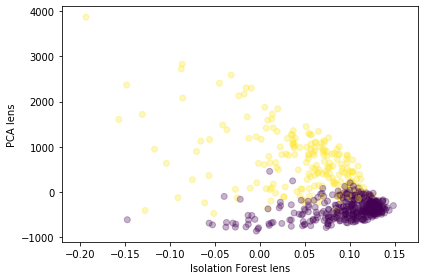

In [19]:
fig, axs = plt.subplots(figsize=(6,4))

axs.scatter(lens1,lens2,c=y.reshape(-1,1),alpha=0.3)
axs.set_xlabel('Isolation Forest lens')
axs.set_ylabel('PCA lens')

plt.tight_layout()

plt.show()

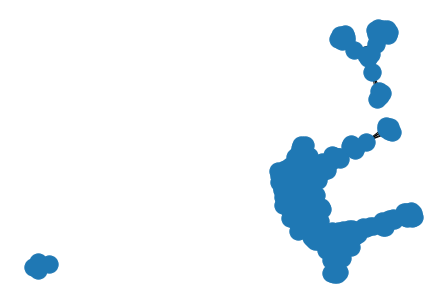

In [20]:
nx_graph = km.adapter.to_nx(graph)
nx.draw(nx_graph)

### Giotto

In [21]:
class OutlierExtractor(TransformerMixin):
    def __init__(self, **kwargs):
        """
        Create a transformer to remove outliers. A threshold is set for selection
        criteria, and further arguments are passed to the LocalOutlierFactor class

        Keyword Args:
            neg_conf_val (float): The threshold for excluding samples with a lower
               negative outlier factor.

        Returns:
            object: to be used as a transformer method as part of Pipeline()
        """
        self.kwargs = kwargs

    def transform(self, X):
        """
        Uses LocalOutlierFactor class to subselect data based on some threshold

        Returns:
            ndarray: subsampled data

        Notes:
            X should be of shape (n_samples, n_features)
        """
        model = IsolationForest(random_state=1729)
        model.fit(X)
        return model.decision_function(X).reshape((X.shape[0], 1))

    def fit(self, *args, **kwargs):
        return self

In [22]:
iso_forest = OutlierExtractor()

In [23]:
lens_union = FeatureUnion(
    [('lens_1', iso_forest), 
     ('lens_2', PCA(n_components=1, random_state=42))]
)

lenses = lens_union.fit_transform(X)

In [24]:
lens.shape

(569, 2)

In [25]:
lenses.shape

(569, 2)

In [26]:
# check cover values match kepler's
assert np.allclose(lens[:,0], lenses[:,0])
assert np.allclose(lens[:,1], lenses[:,1])

In [27]:
lenses[:,0].shape

(569,)

In [28]:
y.shape

(569,)

In [29]:
lens1.shape

(569, 1)

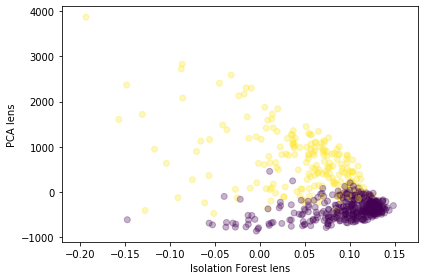

In [30]:
fig, axs = plt.subplots(figsize=(6,4))

axs.scatter(lenses[:,0].reshape(-1,1),lenses[:,1].reshape(-1,1),c=y.reshape(-1,1),alpha=0.3)
axs.set_xlabel('Isolation Forest lens')
axs.set_ylabel('PCA lens')

plt.tight_layout()

plt.show()

In [31]:
filter_func = PCA(n_components=2) #lens_union
cover = CubicalCover(n_intervals=15, overlap_frac=0.7)
clusterer = KMeans(n_clusters=2, random_state=3471)

In [32]:
n_jobs_outer = 1

pipe = make_mapper_pipeline(filter_func=lens_union,
                            cover=cover,
                            clusterer=clusterer,
                            verbose=True,
                            n_jobs_outer=n_jobs_outer)

In [33]:
steps = [
    ('filter_funcs', lens_union),
    ('cover', cover),
    ('clusterer', clusterer)
]

In [169]:
pipe = MapperPipeline(steps = steps, verbose=1)

In [177]:
graph = pipe.fit_transform(X)

[Pipeline] ....... (step 1 of 2) Processing filter_func, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s


ValueError: n_samples=1 should be >= n_clusters=2

In [28]:
KMeans().get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 8,
 'n_init': 10,
 'n_jobs': None,
 'precompute_distances': 'auto',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [159]:
# graph = pipe.fit_transform(X)

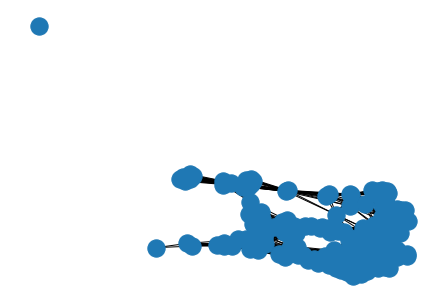

In [175]:
nx.draw(graph)